In [ ]:
import pandas as pd
import numpy as np
import os
import re
#import lightgbm as lgb
import matplotlib.pyplot as plt
from Bio import SeqIO
import h5py

# from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import GenericUnivariateSelect, f_regression, SelectKBest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from transformers import logging

In [ ]:
# things to study

# huggingface transformers
https://huggingface.co/learn/llm-course/chapter1/1?fw=pt

In [ ]:
# Notes

# first use ProtT5 encoder only, half precision model (for speed, no k-mer/window size )
# feed seqs in 1 at a time (batch size 1)

# 1. identify test, train data
    # get embeddings for whole protein
# 2. build models w/ embeddings as input
    # 
# 3. evaluate models

# https://github.com/CalvinRusley/peapod/blob/main/README.md
# https://github.com/WRiegs/Squidly/blob/main/squidly/squidly.py#L265



In [ ]:
# Definitions

## logits = raw/unnormalized predictions generated by model
## softmax = converts logits to probabilities that sum to one
## for classification tasks, softmax function generates a vector of (normalized) probabilities with one value for each possible class


In [ ]:
# prepare your protein sequences as a dict {accession: sequence})
nif = list(SeqIO.parse("example.fasta", "fasta"))
nif_header = [seq_record.id for seq_record in nif]
nif_label = [seq_record.description.split("|")[1] for seq_record in nif]
nif_sequences = [str(seq_record.seq) for seq_record in nif]

# replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
nif_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in nif_sequences]

nif_dict = dict(zip(nif_header, nif_sequences))



In [1]:
# load dependencies
from Bio import SeqIO

from pathlib import Path
import pandas as pd
import re
import os

import torch

from transformers import T5Tokenizer, T5EncoderModel

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

/resnick/groups/enviromics/zahra/miniconda3/envs/protML/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


In [ ]:
# set up model

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/ProstT5").to(device)

#gc.collect()

# # only GPUs support half-precision currently; if you want to run on CPU use full-precision (not recommended, much slower)
model.float() if device=='cpu' else model #.half()

# load fasta files

def process_sequence(seq):
    seq = " ".join(list(re.sub(r"[UZOB]", "X", seq)))
    seq = "<AA2fold>" + " " + seq
    return seq

def load_fasta_by_class(fasta_dir):
    samples = []
    class_to_idx = {}

    for i, fasta_file in enumerate(sorted(Path(fasta_dir).glob("*.fasta"))):
        class_name = fasta_file.stem
        class_to_idx[class_name] = i

        for record in SeqIO.parse(fasta_file, "fasta"):
            samples.append({
                "id": record.id,
                "sequence": process_sequence(str(record.seq)),
                "label": i,
                "class": class_name
            })

    return samples, class_to_idx


# generagte embeddings
def embed_sequence(seq, per_protein=False):

    ids = tokenizer(seq, add_special_tokens=True, padding="longest",return_tensors='pt').to(device)

    # generate embeddings
    with torch.no_grad():
        embedding = model(input_ids=ids.input_ids, attention_mask=ids.attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()

    # Remove special tokens
    embedding = embedding[0, 1:-1]  # shape: (L, d)

    if per_protein:
        embedding = embedding.mean(dim=0)  # shape: (1, d)

    return embedding


# save embeddings

def embed_and_save(samples, out_dir, per_protein=False):
    os.makedirs(out_dir, exist_ok=True)
    metadata = []

    for s in samples:
        emb = embed_sequence(s["sequence"], per_protein=per_protein)

        out_file = Path(out_dir) / f"{s['id'].split('|')[0]}.pt"
        torch.save(emb, out_file)

        metadata.append({
            "id": s["id"],
            "label": s["label"],
            "class": s["class"],
            "length": emb.shape[0],
            "embedding_path": str(out_file)
        })

    return metadata


# main workflow
emb_type = "per-protein"  # or "per-residue"

samples, class_map = load_fasta_by_class("data/fastas")

metadata = embed_and_save(
    samples,
    out_dir=f"data/embeddings/prostt5/{emb_type}/",
    per_protein=emb_type=="per-protein"
)

df = pd.DataFrame(metadata)
df.to_csv(f"data/metadata-{emb_type}.tsv", sep="\t", index=False)

In [16]:
# convert per-reside to per-protein embeddings
from pathlib import Path

df = pd.read_csv("data/metadata.tsv", sep="\t")

out_dir="data/embeddings/prostt5/per-protein/"

torch.serialization.add_safe_globals([np._core.multiarray._reconstruct])
torch.serialization.safe_globals([np.ndarray])


for row in df.itertuples():
    emb = torch.load(row.embedding_path, weights_only=False)
    if emb.ndim == 2:  # per-residue
        emb = emb.mean(axis=0)  # convert to per-protein
        out_file = Path(out_dir) / row.embedding_path.split("/")[-1]
        torch.save(emb, out_file)

## Plotting

In [ ]:
#t-SNE
tsne = TSNE(n_components=2, random_state=int(datetime.now().timestamp())) # set random state to current timestamp for reproducibility
X_tsne = tsne.fit_transform(X)
kl_div = tsne.kl_divergence_

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# normalized PCA
X_pca_norm = (X - np.mean(X, axis=0))/np.std(X, axis=0)
X_pca_norm = pca.fit_transform(X_pca_norm)

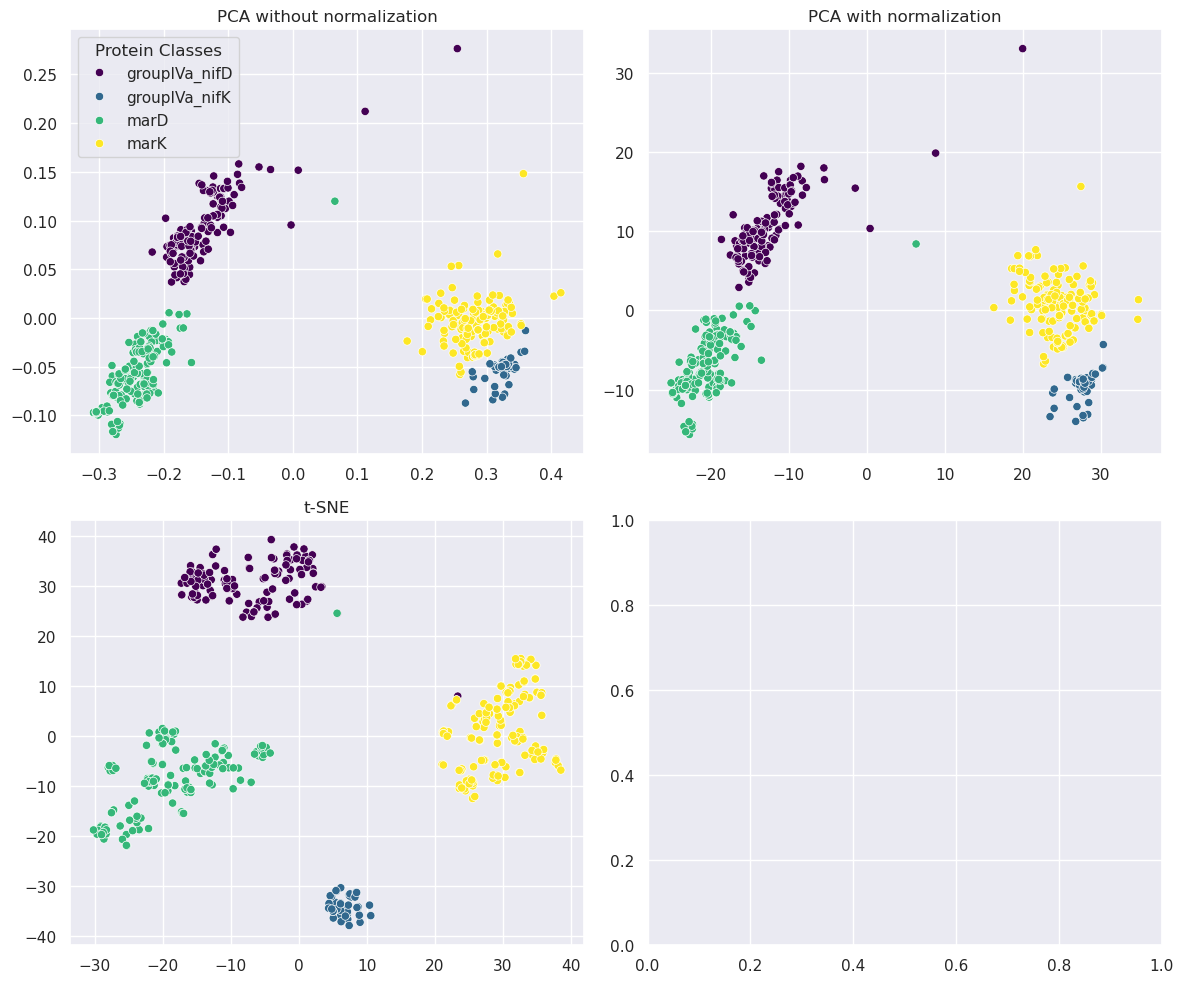

In [21]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12,10))
sns.set()

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', ax=axes[0,0])
axes[0,0].set_title("PCA without normalization")

sns.scatterplot(x=X_pca_norm[:, 0], y=X_pca_norm[:, 1], hue=y, palette='viridis', ax=axes[0,1], legend=False)
axes[0,1].set_title("PCA with normalization")

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', ax=axes[1,0], legend=False)
axes[1,0].set_title("t-SNE")

# add custom legend
handles, labels = axes[0,0].get_legend_handles_labels()
custom_labels = ['groupIVa_nifD', 'groupIVa_nifK', 'marD', 'marK']
axes[0,0].legend(handles=handles, labels=custom_labels, title="Protein Classes")


plt.tight_layout()
plt.show()


In [23]:
# Plotting pLM metric v BLAST SSN

# df = pd.read_csv("data/metadata-per-protein.tsv", sep="\t")

# X = np.array([torch.load(path, weights_only=False) for path in df['embedding_path']])
# y = df['label'].values

# L2 normalization?

# pairwise cosine similarity
cosine_similarities = np.array([torch.nn.functional.cosine_similarity(torch.tensor(X[i]), torch.tensor(X[j]), dim=0).item() for i in range(len(X)) for j in range(i+1, len(X))])

#euclidean_distances = np.array([torch.nn.functional.pairwise_distance(torch.tensor(X[i]), torch.tensor(X[j])).item() for i in range(len(X)) for j in range(i+1, len(X))])

# cosine sim cutoff
num_blast_edges = edge_table.shape[0]

# Find the threshold for cosine similarity that gives us the same number of edges
threshold = np.percentile(cosine_similarities, 100 - (num_blast_edges / len(cosine_similarities) * 100))
print(f"Cosine similarity threshold for {num_blast_edges} edges: {threshold}")




NameError: name 'edge_table' is not defined

### DiazoDB Comparison

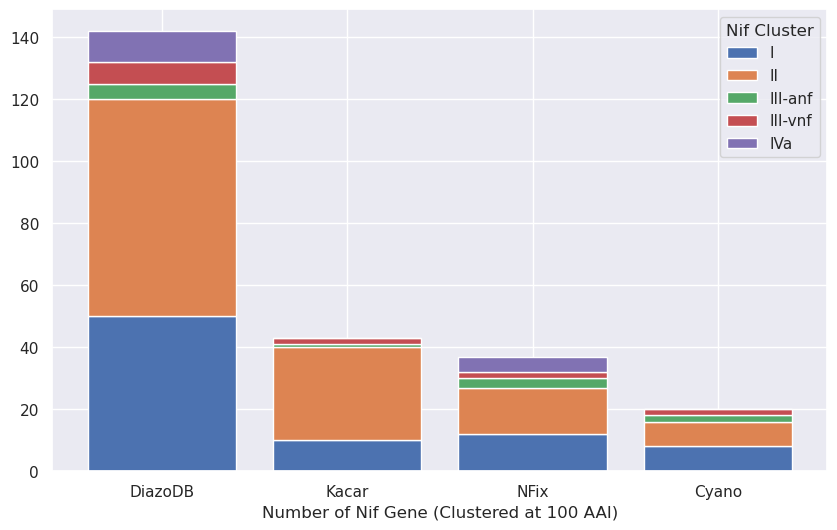

In [35]:
# Figure X: comparing # DiazoDB entries and type to Kacar, NFix, Cyano

# cluster at 100% AAI?
clust = 100

db_list = ['DiazoDB', 'Kacar', 'NFix', 'Cyano']

nif_dict = {'I': np.array([50, 10, 12, 8]), 
            'II': np.array([70, 30, 15, 8]), 
            'III-anf': np.array([5, 1, 3, 2]),
            'III-vnf': np.array([7, 2, 2, 2]),
            'IVa': np.array([10, 0, 5, 0])}

fig = plt.figure(figsize=(10, 6))

# stacked bar plot
bottom = np.zeros(len(db_list))
for key, value in nif_dict.items():
    plt.bar(db_list, value, label=key, bottom=bottom)
    bottom += value


plt.xlabel(f'Number of Nif Gene (Clustered at {clust} AAI)')
plt.legend(title="Nif Cluster")

### Classification

In [ ]:
class EmbeddedProteinDataset(torch.utils.data.Dataset):
    def __init__(self, metadata_tsv):
        self.df = pd.read_csv(metadata_tsv, sep="\t")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        emb = torch.load(row.embedding_path, weights_only=True) # weights_only = False
        return emb, row.label, row.id


In [10]:
def collate_fn(batch): # padding and masking
    embeddings, labels, ids = zip(*batch)

    lengths = [e.shape[0] for e in embeddings]
    d = embeddings[0].shape[1] # embedding dimension (depends on pLM)

    # manual padding
    padded = []
    for e in embeddings:
        # check if padding is needed (along 1st dim)
        if e.shape[0] < max(lengths):
            pad = torch.zeros((max(lengths) - e.shape[0], d)) # create pad so that it has same final dim as longest seq x embedding dim
            padded.append(torch.cat([e, pad], dim=0)) # concatenate along 1st dim, save to padded
        else:
            padded.append(e)


    padded = torch.stack(padded, dim=0) # concat tensors along new dim
    mask = torch.arange(padded.shape[1])[None, :] < torch.tensor(lengths)[:, None] # 1D tensor and masking

    return padded, torch.tensor(labels), mask, ids


In [11]:
class ResidueAttentionClassifier(torch.nn.Module):
    def __init__(self, d_model, n_classes):
        super().__init__() # ?

        self.residue_proj = torch.nn.Sequential(
            torch.nn.Linear(d_model, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        )

        self.attention = torch.nn.Linear(128, 1)
        self.classifier = torch.nn.Linear(128, n_classes)

    def forward(self, x, mask):
        """
        x: (B, L, d)
        mask: (B, L)
        """

        h = self.residue_proj(x)           # (B, L, 128)
        scores = self.attention(h).squeeze(-1)  # (B, L)

        scores = scores.masked_fill(~mask, -1e9)  # mask out padded positions
        weights = torch.softmax(scores, dim=1) # attention weights for each residue

        pooled = (h*weights.unsqueeze(-1)).sum(dim=1) # weighted sum of residue representations
        logits = self.classifier(pooled)

        # attn_logits = attn_logits.masked_fill(~mask, -1e9)
        # attn_weights = torch.softmax(attn_logits, dim=1)

        # pooled = torch.sum(h * attn_weights.unsqueeze(-1), dim=1)
        # logits = self.classifier(pooled)

        return logits, weights


In [12]:
# load dataset
from torch.utils.data import DataLoader, random_split

dataset = EmbeddedProteinDataset("data/metadata.tsv")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
# train loop
device = "cuda" if torch.cuda.is_available() else "cpu"

d_models = {'prost_t5': 1024, 'prot_T5': 1024} # depends on pLM and whether you use half or full precision

model = ResidueAttentionClassifier(
    d_model=d_models['prost_t5'],
    n_classes=len(class_map)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y, mask, _ in loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)

        optimizer.zero_grad()
        logits, _ = model(x, mask)
        loss = criterion(logits, y)

        # # optional sparsity regularization
        # entropy = -(attn * torch.log(attn + 1e-9)).sum(dim=1).mean()
        # loss = loss + 0.001 * entropy

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [14]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    for x, y, mask, _ in loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        logits, _ = model(x, mask)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total


In [15]:
for epoch in range(10):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.4f}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
model = ResidueAttentionClassifier(d_model=1024, n_classes=N)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(50):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc = evaluate(model, test_loader)

    print(f"Epoch {epoch}: loss={train_loss:.3f}, val_acc={val_acc:.3f}")


In [ ]:
@torch.no_grad()
def extract_attention(model, loader):
    model.eval()
    results = []

    for x, y, mask, ids in loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        logits, attn = model(x, mask)

        for i, pid in enumerate(ids):
            L = mask[i].sum().item()
            results.append({
                "id": pid,
                "label": y[i].item(),
                "attention": attn[i, :L].cpu()
            })

    return results


In [ ]:
importance = extract_attention(model, test_loader)
# need to map back to MSA columns

In [ ]:
nif_Yhat = pred_model(emb.mean(dim=0,keepdims=True))
results["mem"][identifier] = torch.max(nif_Yhat, dim=1)[1].detach().cpu().numpy().squeeze()

In [ ]:
# predict on new seqs

input_fasta_file = "input_sequences.fasta"

# create results dataframe
results_df = pd.DataFrame(columns = ['prot_desc', 'position','site_residue', 'probability', 'prediction'])

# load model
combined_model = load_model(model_path)

for seq_record in tqdm(SeqIO.parse(input_fasta_file, "fasta")):
    prot_id = seq_record.id
    sequence = str(seq_record.seq)
    
    positive_predicted = []
    negative_predicted = []
    
    # extract protT5 for full sequence and store in temporary dataframe 
    pt5_all = get_protT5_features(sequence)
    
    # generate embedding features and window for each amino acid in sequence
    for index, amino_acid in enumerate(sequence):
        
        # check if AA is 'K'
        if amino_acid in ['K']:
            
            # we consider site one more than index, as index starts from 0
            site = index + 1
            
            # extract window
            window = extract_one_windows_position(sequence, site)
            
            # extract embedding_encoding
            X_test_embedding = get_input_for_embedding(window)
            
            # get ProtT5 features extracted above
            X_test_pt5 = pt5_all[index]
            
            # prediction results           
            y_pred = combined_model.predict([X_test_embedding.reshape(1, win_size), np.array(X_test_pt5.reshape(1,1024))], verbose = 0)[0][0]
            
            # append results to results_df
            results_df.loc[len(results_df)] = [prot_id, site, amino_acid, y_pred, int(y_pred > cutoff_threshold)]


In [ ]:
# evaluate model on test data

# load test data
test_positive_pt5 = pd.read_csv("data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# create labels
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('data/test/fasta/test_negative_sites.fasta')

# stack positive and negative data together
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

# load saved model
combined_model = load_model(model_path)

# predict test data
y_pred = combined_model.predict([X_test_embedding,X_test_pt5]).reshape(y_test.shape[0],)
y_pred = (y_pred > cutoff_threshold)
y_pred = [int(i) for i in y_pred]
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# calculate performance metrics
cm = confusion_matrix(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n %s, %s, %s, %s, %s \n" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [ ]:
# Visualize correlations between numerical features and the target variable
correlation_matrix = df_train[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Models

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# RF
rf_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=5, n_estimators=10)
rf_clf.fit(X_train_pt5, y_train_pt5)

# SVM
svm_clf = SVC(C = 3, gamma = 0.01, kernel = 'rbf', probability=True)
svm_clf.fit(X_train_pt5, y_train_pt5)

#XGB
xgb_clf = xgb.XGBRegressor(seed = 321, max_depth =  10, learning_rate = 0.01, n_estimators = 100, colsample_bytree = 0.3)
xgb_clf.fit(X_train_pt5, y_train_pt5)

In [ ]:
# Other

Preprocessing
1. Import Data 
2. Subset data (reduce runtime, improve mafft performance)
2. Align sequences (mafft)
3. Encode categorical values (Optional, AA, gene annotations)
4. Collapse AA into functional groups (Optional)

In [ ]:
# align sequences (mafft)
os.system(f"cat in1.fasta in2.fasta > in-merged.fasta")
os.system(f"mafft --auto --quiet in.fasta > out.aln")

# convert to dataframe, add Y (gene annotation)
df = pd.read_csv('out.aln', sep="\t")  # example

Profile/Probabilistic Methods

Statistical Methods
1. ANOVA

In [ ]:
# 1. ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

def OLS_sm(df,
           dependant_var='price',
           numeric_features=[],
           categorical_features=[],
           verbose=False,
           show_summary=True,
           show_plots=True,
           target_is_dollar=True):
    """
    ### Uses formula based statsmodels regression for OLS. ###
    
    Displays a statsmodels.iolib.summary.Summary object containing summary of OLS analysis. 
    Returns a statsmodels.regression.linear_model.RegressionResultsWrapper which can be used to access other options available.

    Parameters:
    ===========
        df = pandas.DataFrame; no default. 
                Input dataset to use for OLS.
        dependant_var = str; default: 'price'. 
                Dependent variable.
        numeric_features = list; default = []. 
                Identify numeric features.
        categorical_features = list; default = []. 
                Identify categorical features.
        verbose = boolean; default: False. 
                Shows some formula used and drop information.
                    `True` shows information.
                    `False` does not show information.
        show_summary = boolean; default: False. 
                Shows summary report.
                    `True` shows information.
                    `False` does not show information.
        show_plots = boolean; default: True. 
                Shows summary and Homoscedasticity information.
                    `True` shows information.
                    `False` does not show information.
        target_is_dollar = boolean; default: True. 
                Modify chart axis label.
                    `True` shows information.
                    `False` does not show information.    
    Under-The-Hood:
    =============
    --{Major Steps}--
        
        ## Regression
        cate = ' + '.join([f'C({x})' for x in categorical_features])
        nume = ' + '.join([f'{x}' for x in numeric_features])
        formula = f'{dependant_var} ~ {nume} + {cate}'
        
        ## plots
        # plot on the left
        sm.qqplot(multiple_regression.resid,
                  dist=stats.norm,
                  line='45',
                  fit=True,
                  ax=ax1)
        # plot on the right
        ax2.scatter(x=multiple_regression.fittedvalues,
                    y=multiple_regression.resid,
                    s=4,
                    color='gold')
    
    Note:
    =====
        Make sure that every column in the DataFrame has the correct dtype.
        Numeric values stored as str (i.e, object) will make stats model assume that those are categorical variable.
        If Erros, check df to see if the passed feature is available in the DataFrame.
    
    Issues:
    =======
        - Output control is not clear.
    
    Changelog:
    ==========
        - changed `resid`, was using `resid_pearson`.
    
    -- ver: 1.3 --
    """
    cate = ' + '.join([f'C({x})' for x in categorical_features])
    nume = ' + '.join([f'{x}' for x in numeric_features])
    if len(cate)==0:
        formula = f'{dependant_var} ~ {nume}'
    else:
        formula = f'{dependant_var} ~ {nume} + {cate}'
    print('Formula for the OLS model: ', formula)
    # OLS regressor
    multiple_regression = smf.ols(formula=formula, data=df).fit()

    if verbose:
        show_summary = True
        show_plots = True

    if show_summary:
        display(multiple_regression.summary())
    if show_plots:
        # plotting
        # plot 1
        fig, (ax1,
              ax2) = plt.subplots(ncols=2,
                                  figsize=(10, 5),
                                  gridspec_kw={'width_ratios': [0.6, 0.4]})
        sm.qqplot(multiple_regression.resid,
                  dist=stats.norm,
                  line='45',
                  fit=True,
                  ax=ax1)
        ax1.set_title('Q-Q Plot', fontdict={"size": 15})
        # plot 2
        # uses The predicted values for the original (unwhitened) design.
        ax2.scatter(x=multiple_regression.fittedvalues, 
                    y=multiple_regression.resid,
                    s=4,
                    color='gold')
        if target_is_dollar:
            ax2.yaxis.set_major_formatter(format_number)
        ax2.set(xlabel='Predicted', ylabel='Residuals')
        ax2.axhline(y=0, c='r', lw=4, ls='--')
        ax2.set_title('Predicted VS Residuals', fontdict={"size": 15})
        plt.suptitle('Visual Check of Residuals for Homoscedasticity',
                     ha='center',
                     va='bottom',
                     fontdict={"size": 25})
        plt.tight_layout()
    if verbose == False and show_summary == False and show_plots == True:
        print('r_sq:', round(multiple_regression.rsquared, 4))
    return multiple_regression

# Univariate ANOVA
''' package can handle categorical variables directly, no need to encode'''

stat_list = []
for idx, column in enumerate(df.columns):
    regression_target = 'annot'
    # for dealing with categorical variables
    temp_df = df.copy()
    for column in df.columns:
        f = f'{regression_target} ~ C({column})'
    model = smf.ols(formula=f, data=temp_df).fit()
    temp_dict = {
        'name': column,
        'r_sq': model.rsquared,
        'intercept': model.params[0],
        'beta': model.params[1],
        'p_val': model.pvalues[1],
        'Jarque-Bera': sms.jarque_bera(model.resid)[0] 
    }
    stat_list.append(temp_dict)
df_stat = pd.DataFrame(stat_list).set_index('name')

# Multivariate ANOVA
OLS_sm(df=df,
       numeric_features=[],
       dependant_var='price',
       categorical_features=df.columns.tolist()[:-1],
       show_summary=False)

ML-based methods (Wrapper?)